# RSI Indicator

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))
from functools import partial

import matplotlib.pyplot as plt
 
import os
import datetime

Tensorflow version: 2.7.0
Mounted at /content/drive


In [3]:
df = pd.read_csv("FE_data.csv")
df = df.iloc[:, 1:]

Indicator = 'RSI'
Timeperiod = '8'

df = df[['High', 'Low', 'Close', 'Volume', Indicator + Timeperiod]]
df

In [ ]:
'''Calculate percentage change'''
 
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()
 
df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
 
###############################################################################
'''Normalize price columns'''
 
 
#COMPUTE THOSE ON TRAINING SET AND ONLY THEN USE TO NORMALIZE

min_return = min(df[['High', 'Low', 'Close']][:int(0.8 * len(df))].min(axis=0))
max_return = max(df[['High', 'Low', 'Close']][:int(0.8 * len(df))].max(axis=0))
 
# Min-max normalize price columns (0-1 range)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''
 
min_volume = df['Volume'][:int(0.8 * len(df))].min(axis=0)
max_volume = df['Volume'][:int(0.8 * len(df))].max(axis=0)
 
# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)
 
###############################################################################

In [ ]:
'''Create training, validation and test split'''
 
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))-1] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))-1] # Last 20% of series
 
df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]
 
# Remove date column
# df_train.drop(columns=['Time'], inplace=True)
# df_val.drop(columns=['Time'], inplace=True)
# df_test.drop(columns=['Time'], inplace=True)
 
# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))
 
df_train.head()

Training data shape: (64975, 5)
Validation data shape: (8122, 5)
Test data shape: (8123, 5)


,High,Low,Close,Volume,RSI8
1,0.559856,0.554443,0.554443,0.000222,0.026095
2,0.547679,0.550383,0.549030,0.000035,-0.413806
3,0.559855,0.553090,0.562565,0.000171,0.537873
4,0.554442,0.559858,0.555795,0.000037,0.748994
5,0.553090,0.554443,0.551737,0.000073,0.575511


In [ ]:
seq_len = 16
 
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[:, :len(df.columns)-1][i-seq_len:i])
  y_train.append(train_data[:, len(df.columns)-1][i-1])
X_train, y_train = np.array(X_train), np.array(y_train)
 
###############################################################################
 
# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[:, :len(df.columns)-1][i-seq_len:i])
    y_val.append(val_data[:, len(df.columns)-1][i-1])
    #y_val.append(0.5*val_data[:, 31][i-1]+ 0.5*val_data[:, 30][i-1])
X_val, y_val = np.array(X_val), np.array(y_val)
 
###############################################################################
 
# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[:, :len(df.columns)-1][i-seq_len:i])
    y_test.append(test_data[:, len(df.columns)-1][i-1])    
    #y_test.append(0.5*test_data[:, 31][i-1]+ 0.5*test_data[:, 30][i-1])
X_test, y_test = np.array(X_test), np.array(y_test)
 
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(64959, 16, 4) (64959,)
(8106, 16, 4) (8106,)


In [ ]:
def make_model(base_feat = 128):

    inp = Input(shape=(seq_len,X_train.shape[2]))
    x = BatchNormalization()(inp)

    x = LSTM(64, return_sequences = False)(x)
    x = BatchNormalization()(x)
    
    x = Dense(64, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(loss='mse', 
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics = ['mae'])
    return model

In [ ]:
tf.keras.backend.clear_session()
model = make_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 4)]           0         
                                                                 
 batch_normalization (BatchN  (None, 16, 4)            16        
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 64)                17664     
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256   

In [ ]:
history = model.fit(X_train, y_train,
          epochs=2000,
          #validation_data=(X_val, y_val),
          #callbacks=[tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=15)],
          batch_size = 128,
          steps_per_epoch = 40
          )

Epoch 1/2000
40/40 [==============================] - 0s 8ms/step - loss: 0.0253 - mae: 0.1206
Epoch 2/2000
40/40 [==============================] - 0s 8ms/step - loss: 0.0301 - mae: 0.1332
Epoch 3/2000
40/40 [==============================] - 0s 7ms/step - loss: 0.0312 - mae: 0.1359
Epoch 4/2000
40/40 [==============================] - 0s 7ms/step - loss: 0.0256 - mae: 0.1231
Epoch 5/2000
40/40 [==============================] - 0s 8ms/step - loss: 0.0257 - mae: 0.1226
Epoch 6/2000
40/40 [==============================] - 0s 8ms/step - loss: 0.0273 - mae: 0.1269
Epoch 7/2000
40/40 [==============================] - 0s 8ms/step - loss: 0.0270 - mae: 0.1278
Epoch 8/2000
40/40 [==============================] - 0s 8ms/step - loss: 0.0236 - mae: 0.1166
Epoch 9/2000
40/40 [==============================] - 0s 8ms/step - loss: 0.0253 - mae: 0.1212
Epoch 10/2000
40/40 [==============================] - 0s 8ms/step - loss: 0.0286 - mae: 0.1298
Epoch 11/2000
40/40 [============================

In [ ]:
###############################################################################
'''Calculate predictions and metrics'''

#training_model.load_weights('epoch25.h5')
#model = training_model
 

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

train_eval = model.evaluate(X_train, y_train, verbose=1)
val_eval = model.evaluate(X_val, y_val, verbose=1)
test_eval = model.evaluate(X_test, y_test, verbose=1)


254/254 [==============================] - 1s 4ms/step - loss: 0.0290 - mae: 0.1280


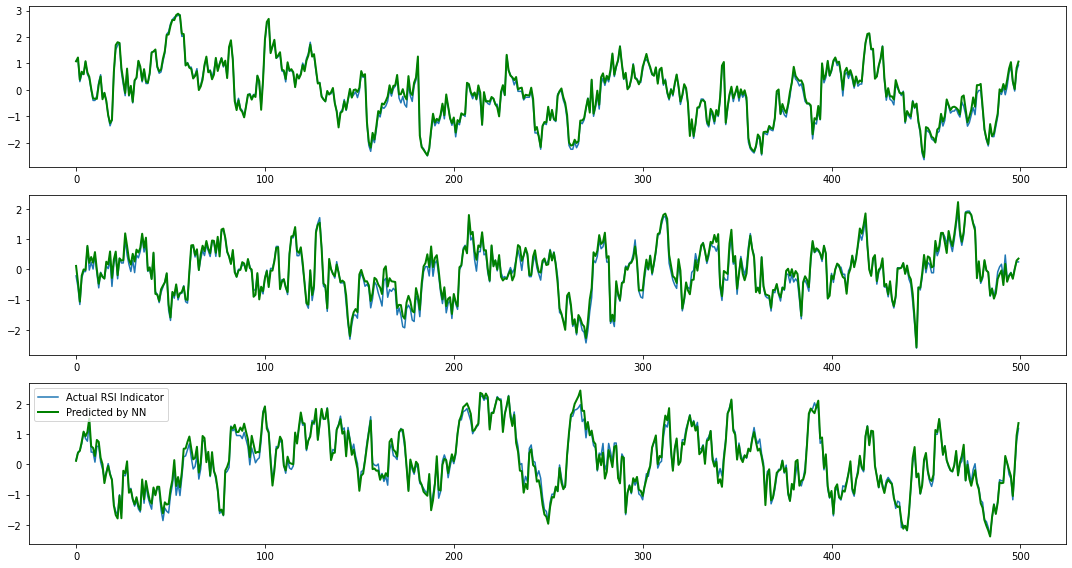

In [ ]:
fig = plt.figure(figsize=(15,8))
 
#st = 1300
st = 1300
p = 500
 
train_data1 = train_data[seq_len:]
val_data1 = val_data[seq_len:]
test_data1 = test_data[seq_len:]
 
 
 
#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(y_train[st: st+p])
ax11.plot(train_pred[st:st+p], color='green', linewidth=2, label='Predicted')
 
#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(y_val[st: st+p])
ax21.plot(val_pred[st: st+p], color='green', linewidth=2, label='Predicted')

 
#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(y_test[st: st+p], label='Actual RSI Indicator')
ax31.plot(test_pred[st: st+p], color='green', linewidth=2, label='Predicted by NN')
 
'''
ax41 = fig.add_subplot(414)
ax41.plot(X_test[:, ][st: st+p])
'''
 
plt.tight_layout()
plt.legend(loc='best')

# ADX

In [ ]:
df = pd.read_csv("FE_data.csv")
df = df.iloc[:, 1:]

Indicator = 'ADX'
Timeperiod = '36'

# Indicators : EMA, ROC, ADX, NATR, UO

df = df[['High', 'Low', 'Close', 'Volume', Indicator + Timeperiod]]
df

,High,Low,Close,Volume,ADX36
0,115580.0,115560.0,115570.0,210,-0.921960
1,115630.0,115570.0,115580.0,623,-0.937562
2,115590.0,115550.0,115550.0,290,-0.949478
3,115640.0,115550.0,115620.0,664,-0.970523
4,115650.0,115600.0,115640.0,333,-0.992872
...,...,...,...,...,...
81216,114620.0,114520.0,114570.0,856,-1.053856
81217,114600.0,114500.0,114510.0,598,-1.059452
81218,114680.0,114470.0,114630.0,2273,-1.079961
81219,114700.0,114600.0,114680.0,544,-1.103588


In [ ]:
'''Calculate percentage change'''
 
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()
 
df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
 
###############################################################################
'''Normalize price columns'''
 
 
#COMPUTE THOSE ON TRAINING SET AND ONLY THEN USE TO NORMALIZE

min_return = min(df[['High', 'Low', 'Close']][:int(0.8 * len(df))].min(axis=0))
max_return = max(df[['High', 'Low', 'Close']][:int(0.8 * len(df))].max(axis=0))
 
# Min-max normalize price columns (0-1 range)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''
 
min_volume = df['Volume'][:int(0.8 * len(df))].min(axis=0)
max_volume = df['Volume'][:int(0.8 * len(df))].max(axis=0)
 
# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)
 
###############################################################################

In [ ]:
'''Create training, validation and test split'''
 
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))-1] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))-1] # Last 20% of series
 
df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]
 
# Remove date column
# df_train.drop(columns=['Time'], inplace=True)
# df_val.drop(columns=['Time'], inplace=True)
# df_test.drop(columns=['Time'], inplace=True)
 
# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))
 
df_train.head()

Training data shape: (64975, 5)
Validation data shape: (8122, 5)
Test data shape: (8123, 5)


,High,Low,Close,Volume,ADX36
1,0.559856,0.554443,0.554443,0.000222,-0.937562
2,0.547679,0.550383,0.549030,0.000035,-0.949478
3,0.559855,0.553090,0.562565,0.000171,-0.970523
4,0.554442,0.559858,0.555795,0.000037,-0.992872
5,0.553090,0.554443,0.551737,0.000073,-1.014601


In [ ]:
seq_len = 108
 
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[:, :len(df.columns)-1][i-seq_len:i])
  y_train.append(train_data[:, len(df.columns)-1][i-1])
X_train, y_train = np.array(X_train), np.array(y_train)
 
###############################################################################
 
# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[:, :len(df.columns)-1][i-seq_len:i])
    y_val.append(val_data[:, len(df.columns)-1][i-1])
    #y_val.append(0.5*val_data[:, 31][i-1]+ 0.5*val_data[:, 30][i-1])
X_val, y_val = np.array(X_val), np.array(y_val)
 
###############################################################################
 
# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[:, :len(df.columns)-1][i-seq_len:i])
    y_test.append(test_data[:, len(df.columns)-1][i-1])    
    #y_test.append(0.5*test_data[:, 31][i-1]+ 0.5*test_data[:, 30][i-1])
X_test, y_test = np.array(X_test), np.array(y_test)
 
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(64867, 108, 4) (64867,)
(8014, 108, 4) (8014,)


In [ ]:
def make_model(base_feat = 128):

    inp = Input(shape=(seq_len,X_train.shape[2]))
    x = BatchNormalization()(inp)
    x = Dense(32, activation = None)(x)
    x = BatchNormalization()(x)
    x = Activation(partial(tf.nn.leaky_relu, alpha = 0.01))(x)
    x = Dense(64, activation = None)(x)
    x = BatchNormalization()(x)
    x = Activation(partial(tf.nn.leaky_relu, alpha = 0.01))(x)
    x = Dense(128, activation = None)(x)
    x = BatchNormalization()(x)
    x = Activation(partial(tf.nn.leaky_relu, alpha = 0.01))(x)
    x = Dense(256, activation = None)(x)
    x = BatchNormalization()(x)
    x = Activation(partial(tf.nn.leaky_relu, alpha = 0.01))(x)


    x = LSTM(128, return_sequences = True)(x)
    x = LSTM(128, return_sequences = False)(x)
    x = BatchNormalization()(x)
    
    x = Dense(128, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(loss='mse', 
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics = ['mae'])
    return model

In [ ]:
tf.keras.backend.clear_session()
model = make_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 108, 4)]          0         
                                                                 
 batch_normalization (BatchN  (None, 108, 4)           16        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 108, 32)           160       
                                                                 
 batch_normalization_1 (Batc  (None, 108, 32)          128       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 108, 32)           0         
                                                                 
 dense_1 (Dense)             (None, 108, 64)           2112  

In [ ]:
history = model.fit(X_train, y_train,
          epochs=500,
          #validation_data=(X_val, y_val),
          #callbacks=[tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=15)],
          batch_size = 128,
          steps_per_epoch = 40,
          verbose = 1
          )

Epoch 1/500
40/40 [==============================] - 7s 31ms/step - loss: 1.2005 - mae: 0.8594
Epoch 2/500
40/40 [==============================] - 1s 31ms/step - loss: 0.8848 - mae: 0.7320
Epoch 3/500
40/40 [==============================] - 1s 31ms/step - loss: 0.4547 - mae: 0.5239
Epoch 4/500
40/40 [==============================] - 1s 31ms/step - loss: 0.3293 - mae: 0.4417
Epoch 5/500
40/40 [==============================] - 1s 31ms/step - loss: 0.2743 - mae: 0.3986
Epoch 6/500
40/40 [==============================] - 1s 31ms/step - loss: 0.2028 - mae: 0.3469
Epoch 7/500
40/40 [==============================] - 1s 31ms/step - loss: 0.2031 - mae: 0.3459
Epoch 8/500
40/40 [==============================] - 1s 31ms/step - loss: 0.1815 - mae: 0.3304
Epoch 9/500
40/40 [==============================] - 1s 31ms/step - loss: 0.1865 - mae: 0.3346
Epoch 10/500
40/40 [==============================] - 1s 31ms/step - loss: 0.1658 - mae: 0.3130
Epoch 11/500
40/40 [=============================

In [ ]:
###############################################################################
'''Calculate predictions and metrics'''

#training_model.load_weights('epoch25.h5')
#model = training_model
 

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

train_eval = model.evaluate(X_train, y_train, verbose=1)
val_eval = model.evaluate(X_val, y_val, verbose=1)
test_eval = model.evaluate(X_test, y_test, verbose=1)


251/251 [==============================] - 3s 11ms/step - loss: 0.4066 - mae: 0.4604


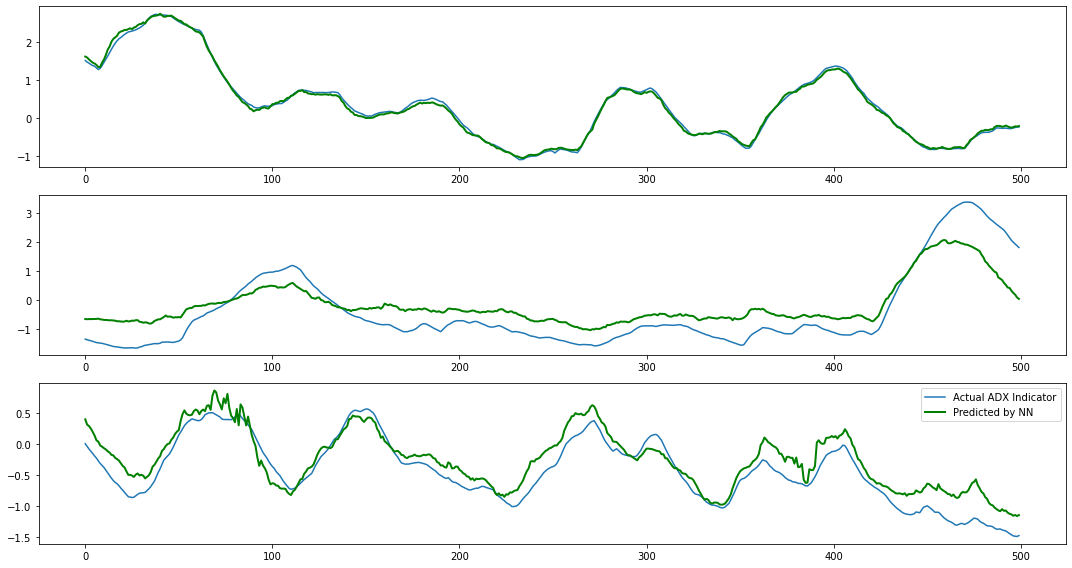

In [ ]:
fig = plt.figure(figsize=(15,8))
 
#st = 1300
st = 1300
p = 500
 
train_data1 = train_data[seq_len:]
val_data1 = val_data[seq_len:]
test_data1 = test_data[seq_len:]
 
 
 
#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(y_train[st: st+p])
ax11.plot(train_pred[st:st+p], color='green', linewidth=2, label='Predicted')
 
#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(y_val[st: st+p])
ax21.plot(val_pred[st: st+p], color='green', linewidth=2, label='Predicted')

 
#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(y_test[st: st+p], label='Actual ADX Indicator')
ax31.plot(test_pred[st: st+p], color='green', linewidth=2, label='Predicted by NN')
 
'''
ax41 = fig.add_subplot(414)
ax41.plot(X_test[:, ][st: st+p])
'''
 
plt.tight_layout()
plt.legend(loc='best')

# ROC

In [ ]:
df = pd.read_csv("FE_data.csv")
df = df.iloc[:, 1:]

Indicator = 'ROC'
Timeperiod = '36'

df = df[['High', 'Low', 'Close', 'Volume', Indicator + Timeperiod]]
df

,High,Low,Close,Volume,ROC36
0,115580.0,115560.0,115570.0,210,-0.553736
1,115630.0,115570.0,115580.0,623,-0.567776
2,115590.0,115550.0,115550.0,290,-0.779000
3,115640.0,115550.0,115620.0,664,-0.567581
4,115650.0,115600.0,115640.0,333,-0.482965
...,...,...,...,...,...
81216,114620.0,114520.0,114570.0,856,-0.473214
81217,114600.0,114500.0,114510.0,598,-0.359505
81218,114680.0,114470.0,114630.0,2273,0.112123
81219,114700.0,114600.0,114680.0,544,-0.002370


In [ ]:
'''Calculate percentage change'''
 
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()
 
df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
 
###############################################################################
'''Normalize price columns'''
 
 
#COMPUTE THOSE ON TRAINING SET AND ONLY THEN USE TO NORMALIZE

min_return = min(df[['High', 'Low', 'Close']][:int(0.8 * len(df))].min(axis=0))
max_return = max(df[['High', 'Low', 'Close']][:int(0.8 * len(df))].max(axis=0))
 
# Min-max normalize price columns (0-1 range)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''
 
min_volume = df['Volume'][:int(0.8 * len(df))].min(axis=0)
max_volume = df['Volume'][:int(0.8 * len(df))].max(axis=0)
 
# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)
 
###############################################################################

In [ ]:
'''Create training, validation and test split'''
 
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))-1] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))-1] # Last 20% of series
 
df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]
 
# Remove date column
# df_train.drop(columns=['Time'], inplace=True)
# df_val.drop(columns=['Time'], inplace=True)
# df_test.drop(columns=['Time'], inplace=True)
 
# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))
 
df_train.head()

Training data shape: (64975, 5)
Validation data shape: (8122, 5)
Test data shape: (8123, 5)


,High,Low,Close,Volume,ROC36
1,0.559856,0.554443,0.554443,0.000222,-0.567776
2,0.547679,0.550383,0.549030,0.000035,-0.779000
3,0.559855,0.553090,0.562565,0.000171,-0.567581
4,0.554442,0.559858,0.555795,0.000037,-0.482965
5,0.553090,0.554443,0.551737,0.000073,-0.511191


In [ ]:
seq_len = 108
 
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[:, :len(df.columns)-1][i-seq_len:i])
  y_train.append(train_data[:, len(df.columns)-1][i-1])
X_train, y_train = np.array(X_train), np.array(y_train)
 
###############################################################################
 
# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[:, :len(df.columns)-1][i-seq_len:i])
    y_val.append(val_data[:, len(df.columns)-1][i-1])
    #y_val.append(0.5*val_data[:, 31][i-1]+ 0.5*val_data[:, 30][i-1])
X_val, y_val = np.array(X_val), np.array(y_val)
 
###############################################################################
 
# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[:, :len(df.columns)-1][i-seq_len:i])
    y_test.append(test_data[:, len(df.columns)-1][i-1])    
    #y_test.append(0.5*test_data[:, 31][i-1]+ 0.5*test_data[:, 30][i-1])
X_test, y_test = np.array(X_test), np.array(y_test)
 
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(64867, 108, 4) (64867,)
(8014, 108, 4) (8014,)


In [ ]:
def make_model(base_feat = 128):

    inp = Input(shape=(seq_len,X_train.shape[2]))
    x = BatchNormalization()(inp)
    
    x = LSTM(128, return_sequences = True)(x)
    x = LSTM(64, return_sequences = False)(x)
    x = BatchNormalization()(x)
    
    x = Dense(64, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    out = Dense(1, activation = 'linear')(x)
    model = Model(inp, out)
    model.compile(loss='mse', 
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics = ['mae'])
    return model

In [ ]:
tf.keras.backend.clear_session()
model = make_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 108, 4)]          0         
                                                                 
 batch_normalization (BatchN  (None, 108, 4)           16        
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 108, 128)          68096     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 64)                4160  

In [ ]:
history = model.fit(X_train, y_train,
          epochs=600,
          #validation_data=(X_val, y_val),
          #callbacks=[tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=15)],
          batch_size = 128,
          steps_per_epoch = 40
          )

Epoch 1/600
40/40 [==============================] - 5s 20ms/step - loss: 0.2250 - mae: 0.3199
Epoch 2/600
40/40 [==============================] - 1s 20ms/step - loss: 0.1178 - mae: 0.2362
Epoch 3/600
40/40 [==============================] - 1s 20ms/step - loss: 0.1191 - mae: 0.2279
Epoch 4/600
40/40 [==============================] - 1s 20ms/step - loss: 0.1055 - mae: 0.2213
Epoch 5/600
40/40 [==============================] - 1s 20ms/step - loss: 0.1356 - mae: 0.2304
Epoch 6/600
40/40 [==============================] - 1s 20ms/step - loss: 0.0994 - mae: 0.2063
Epoch 7/600
40/40 [==============================] - 1s 20ms/step - loss: 0.0893 - mae: 0.1941
Epoch 8/600
40/40 [==============================] - 1s 20ms/step - loss: 0.0825 - mae: 0.2064
Epoch 9/600
40/40 [==============================] - 1s 20ms/step - loss: 0.0746 - mae: 0.1900
Epoch 10/600
40/40 [==============================] - 1s 20ms/step - loss: 0.0693 - mae: 0.1793
Epoch 11/600
40/40 [=============================

In [ ]:
###############################################################################
'''Calculate predictions and metrics'''

#training_model.load_weights('epoch25.h5')
#model = training_model
 

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

train_eval = model.evaluate(X_train, y_train, verbose=1)
val_eval = model.evaluate(X_val, y_val, verbose=1)
test_eval = model.evaluate(X_test, y_test, verbose=1)


251/251 [==============================] - 2s 7ms/step - loss: 0.0444 - mae: 0.1850


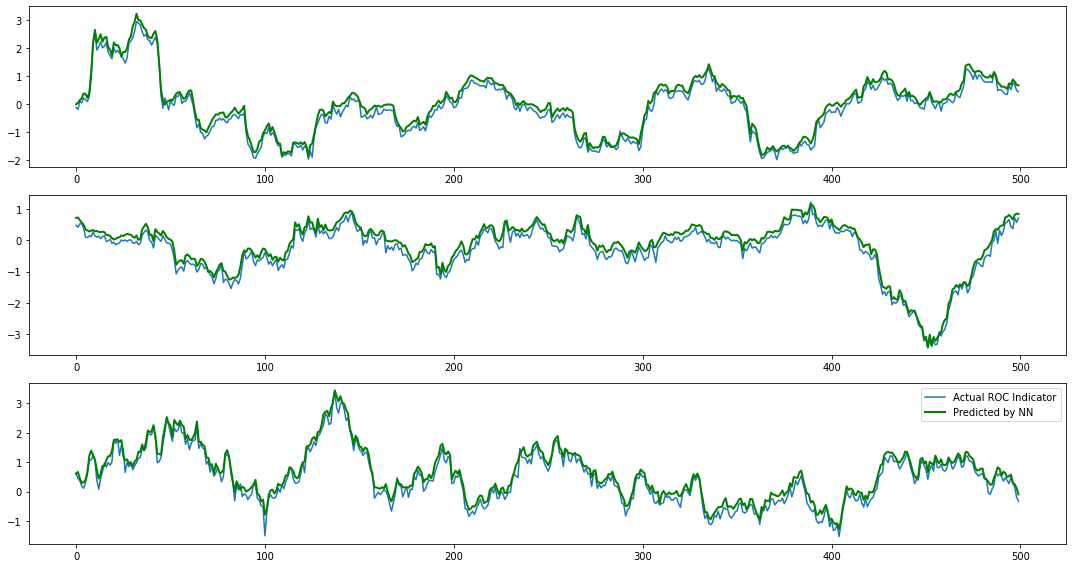

In [ ]:
fig = plt.figure(figsize=(15,8))
 
#st = 1300
st = 1300
p = 500
 
train_data1 = train_data[seq_len:]
val_data1 = val_data[seq_len:]
test_data1 = test_data[seq_len:]
 
 
 
#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(y_train[st: st+p])
ax11.plot(train_pred[st:st+p], color='green', linewidth=2, label='Predicted')
 
#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(y_val[st: st+p])
ax21.plot(val_pred[st: st+p], color='green', linewidth=2, label='Predicted')

 
#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(y_test[st: st+p], label='Actual ROC Indicator')
ax31.plot(test_pred[st: st+p], color='green', linewidth=2, label='Predicted by NN')
 
'''
ax41 = fig.add_subplot(414)
ax41.plot(X_test[:, ][st: st+p])
'''
 
plt.tight_layout()
plt.legend(loc='best')

# NATR

In [ ]:
df = pd.read_csv("FE_data.csv")
df = df.iloc[:, 1:]

Indicator = 'NATR'
Timeperiod = '36'

# Indicators : EMA, ROC, ADX, NATR, UO

df = df[['High', 'Low', 'Close', 'Volume', Indicator + Timeperiod]]
df

,High,Low,Close,Volume,NATR36
0,115580.0,115560.0,115570.0,210,-0.564942
1,115630.0,115570.0,115580.0,623,-0.596270
2,115590.0,115550.0,115550.0,290,-0.635891
3,115640.0,115550.0,115620.0,664,-0.651479
4,115650.0,115600.0,115640.0,333,-0.685534
...,...,...,...,...,...
81216,114620.0,114520.0,114570.0,856,-0.358195
81217,114600.0,114500.0,114510.0,598,-0.373600
81218,114680.0,114470.0,114630.0,2273,-0.337381
81219,114700.0,114600.0,114680.0,544,-0.355684


In [ ]:
'''Calculate percentage change'''
 
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()
 
df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
 
###############################################################################
'''Normalize price columns'''
 
 
#COMPUTE THOSE ON TRAINING SET AND ONLY THEN USE TO NORMALIZE

min_return = min(df[['High', 'Low', 'Close']][:int(0.8 * len(df))].min(axis=0))
max_return = max(df[['High', 'Low', 'Close']][:int(0.8 * len(df))].max(axis=0))
 
# Min-max normalize price columns (0-1 range)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''
 
min_volume = df['Volume'][:int(0.8 * len(df))].min(axis=0)
max_volume = df['Volume'][:int(0.8 * len(df))].max(axis=0)
 
# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)
 
###############################################################################

In [ ]:
'''Create training, validation and test split'''
 
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))-1] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))-1] # Last 20% of series
 
df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]
 
# Remove date column
# df_train.drop(columns=['Time'], inplace=True)
# df_val.drop(columns=['Time'], inplace=True)
# df_test.drop(columns=['Time'], inplace=True)
 
# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))
 
df_train.head()

Training data shape: (64975, 5)
Validation data shape: (8122, 5)
Test data shape: (8123, 5)


,High,Low,Close,Volume,NATR36
1,0.559856,0.554443,0.554443,0.000222,-0.596270
2,0.547679,0.550383,0.549030,0.000035,-0.635891
3,0.559855,0.553090,0.562565,0.000171,-0.651479
4,0.554442,0.559858,0.555795,0.000037,-0.685534
5,0.553090,0.554443,0.551737,0.000073,-0.723061


In [ ]:
seq_len = 108
 
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[:, :len(df.columns)-1][i-seq_len:i])
  y_train.append(train_data[:, len(df.columns)-1][i-1])
X_train, y_train = np.array(X_train), np.array(y_train)
 
###############################################################################
 
# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[:, :len(df.columns)-1][i-seq_len:i])
    y_val.append(val_data[:, len(df.columns)-1][i-1])
    #y_val.append(0.5*val_data[:, 31][i-1]+ 0.5*val_data[:, 30][i-1])
X_val, y_val = np.array(X_val), np.array(y_val)
 
###############################################################################
 
# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[:, :len(df.columns)-1][i-seq_len:i])
    y_test.append(test_data[:, len(df.columns)-1][i-1])    
    #y_test.append(0.5*test_data[:, 31][i-1]+ 0.5*test_data[:, 30][i-1])
X_test, y_test = np.array(X_test), np.array(y_test)
 
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(64867, 108, 4) (64867,)
(8014, 108, 4) (8014,)


In [ ]:
def make_model(base_feat = 128):

    inp = Input(shape=(seq_len,X_train.shape[2]))
    x = BatchNormalization()(inp)
    x = Dense(32, activation = None)(x)
    x = BatchNormalization()(x)
    x = Activation(partial(tf.nn.leaky_relu, alpha = 0.01))(x)
    x = Dense(64, activation = None)(x)
    x = BatchNormalization()(x)
    x = Activation(partial(tf.nn.leaky_relu, alpha = 0.01))(x)
    x = Dense(128, activation = None)(x)
    x = BatchNormalization()(x)
    x = Activation(partial(tf.nn.leaky_relu, alpha = 0.01))(x)
    x = Dense(256, activation = None)(x)
    x = BatchNormalization()(x)
    x = Activation(partial(tf.nn.leaky_relu, alpha = 0.01))(x)

    x = LSTM(128, return_sequences = True)(x)
    
    x = LSTM(128, return_sequences = False)(x)
    x = BatchNormalization()(x)
    
    x = Dense(128, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation = partial(tf.nn.leaky_relu, alpha=0.01))(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(loss='mse', 
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics = ['mae'])
    return model

In [ ]:
tf.keras.backend.clear_session()
model = make_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 108, 4)]          0         
                                                                 
 batch_normalization (BatchN  (None, 108, 4)           16        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 108, 32)           160       
                                                                 
 batch_normalization_1 (Batc  (None, 108, 32)          128       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 108, 32)           0         
                                                                 
 dense_1 (Dense)             (None, 108, 64)           2112  

In [ ]:
history = model.fit(X_train, y_train,
          epochs=500,
          #validation_data=(X_val, y_val),
          #callbacks=[tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=15)],
          batch_size = 128,
          steps_per_epoch = 40,
          verbose = 1
          )

Epoch 1/500
40/40 [==============================] - 1s 31ms/step - loss: 0.0068 - mae: 0.0591
Epoch 2/500
40/40 [==============================] - 1s 30ms/step - loss: 0.0057 - mae: 0.0575
Epoch 3/500
40/40 [==============================] - 1s 30ms/step - loss: 0.0048 - mae: 0.0507
Epoch 4/500
40/40 [==============================] - 1s 30ms/step - loss: 0.0066 - mae: 0.0606
Epoch 5/500
40/40 [==============================] - 1s 30ms/step - loss: 0.0045 - mae: 0.0511
Epoch 6/500
40/40 [==============================] - 1s 30ms/step - loss: 0.0047 - mae: 0.0521
Epoch 7/500
40/40 [==============================] - 1s 30ms/step - loss: 0.0045 - mae: 0.0481
Epoch 8/500
40/40 [==============================] - 1s 30ms/step - loss: 0.0055 - mae: 0.0546
Epoch 9/500
40/40 [==============================] - 1s 29ms/step - loss: 0.0075 - mae: 0.0586
Epoch 10/500
40/40 [==============================] - 1s 30ms/step - loss: 0.0065 - mae: 0.0560
Epoch 11/500
40/40 [=============================

In [ ]:
###############################################################################
'''Calculate predictions and metrics'''

#training_model.load_weights('epoch25.h5')
#model = training_model
 

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

train_eval = model.evaluate(X_train, y_train, verbose=1)
val_eval = model.evaluate(X_val, y_val, verbose=1)
test_eval = model.evaluate(X_test, y_test, verbose=1)


251/251 [==============================] - 3s 10ms/step - loss: 0.0729 - mae: 0.1904


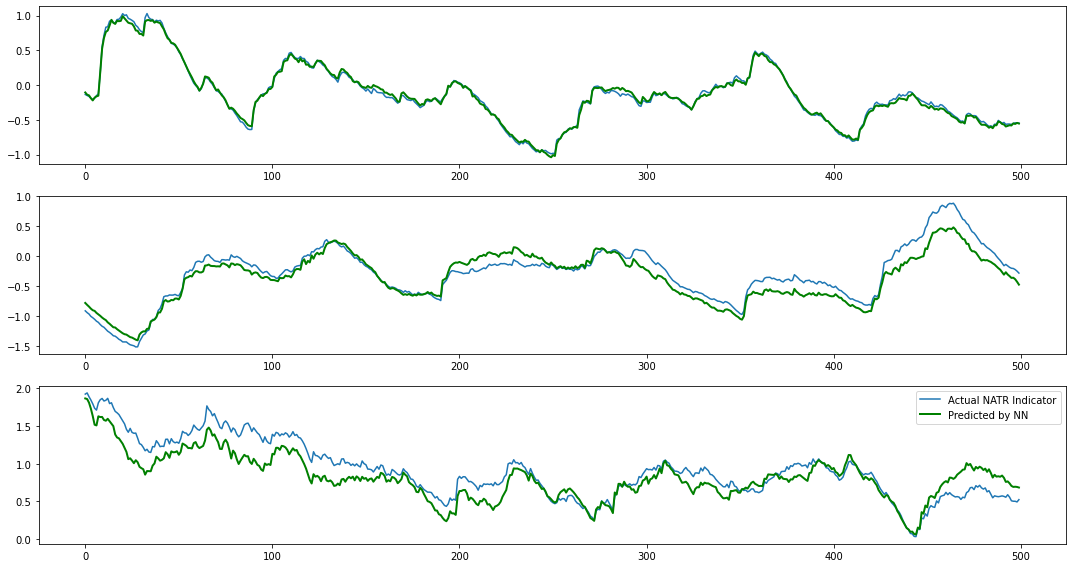

In [ ]:
fig = plt.figure(figsize=(15,8))
 
#st = 1300
st = 1300
p = 500
 
train_data1 = train_data[seq_len:]
val_data1 = val_data[seq_len:]
test_data1 = test_data[seq_len:]
 
 
 
#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(y_train[st: st+p])
ax11.plot(train_pred[st:st+p], color='green', linewidth=2, label='Predicted')
 
#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(y_val[st: st+p])
ax21.plot(val_pred[st: st+p], color='green', linewidth=2, label='Predicted')

 
#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(y_test[st: st+p], label='Actual NATR Indicator')
ax31.plot(test_pred[st: st+p], color='green', linewidth=2, label='Predicted by NN')
 
'''
ax41 = fig.add_subplot(414)
ax41.plot(X_test[:, ][st: st+p])
'''
 
plt.tight_layout()
plt.legend(loc='best')